In [1]:
import os
import joblib

import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

2024-05-24 17:32:41.066877: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-24 17:32:42.930152: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-24 17:33:02.761998: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df = pd.read_csv("/home/riri/Desktop/Soiling/datasets/soiling.csv")
df.head()

,client,gender,age,hours_slept,sleep_quality,main_food_taken,food_taken_amount,drink,temperature(deg),exercise,medication,breakfast_time,lunch_time,supper_time,visit_restroom,times_visited,avg_relieve_time(min),soiled
0,Fox,Female,8,8,Excellent,Ugali,Normal,Porridge,23.8,Yes,Yes,08:14,13:30,19:31,Yes,3,16,No
1,Charlton,Female,7,8,Excellent,Chapati,Small,Milk,23.2,No,Yes,08:53,12:32,18:28,No,0,18,No
2,Iqbal,Male,7,7,Excellent,Meat,Heavy,Porridge,18.7,No,Yes,09:43,13:22,19:23,No,0,19,No
3,Marc,Female,10,7,Excellent,Snacks,Normal,Coffee,18.2,No,No,09:46,13:16,19:32,No,0,22,Yes
4,King,Female,14,6,Good,Veggies,Normal,Water,20.1,Yes,No,08:57,13:55,18:05,Yes,4,18,No


In [5]:
df['target'] = np.where(df['soiled'] == 'Yes', 1, 0)
df.rename({'avg_relieve_time(min)': 'target2' }, axis=1, inplace=True)
df.head()

,client,gender,age,hours_slept,sleep_quality,main_food_taken,food_taken_amount,drink,temperature(deg),exercise,medication,breakfast_time,lunch_time,supper_time,visit_restroom,times_visited,target2,soiled,target
0,Fox,Female,8,8,Excellent,Ugali,Normal,Porridge,23.8,Yes,Yes,08:14,13:30,19:31,Yes,3,16,No,0
1,Charlton,Female,7,8,Excellent,Chapati,Small,Milk,23.2,No,Yes,08:53,12:32,18:28,No,0,18,No,0
2,Iqbal,Male,7,7,Excellent,Meat,Heavy,Porridge,18.7,No,Yes,09:43,13:22,19:23,No,0,19,No,0
3,Marc,Female,10,7,Excellent,Snacks,Normal,Coffee,18.2,No,No,09:46,13:16,19:32,No,0,22,Yes,1
4,King,Female,14,6,Good,Veggies,Normal,Water,20.1,Yes,No,08:57,13:55,18:05,Yes,4,18,No,0


In [6]:
df.drop(columns=['client', 'breakfast_time', 'lunch_time', 'supper_time', 'soiled'], inplace=True)

In [7]:
print(df.shape)

(28532, 14)


In [7]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

In [9]:
# train, test = train_test_split(df, test_size=0.2)
# train, valid = train_test_split(train, test_size=0.2)
print(len(train), "training examples")
print(len(test), "test examples")
print(len(val), "validation examples")

22825 training examples
2854 test examples
2853 validation examples


- Input pipeline.

In [10]:
def transform_df(dataframe: pd.DataFrame, shuffle: bool=True, batch_size: int=32):
    df = dataframe.copy()
    lables = df.pop('target')
    df = {key: value.values[:,tf.newaxis] for key, value in dataframe.items()}
    ds = tf.data.Dataset.from_tensor_slices((dict(df), lables))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds

In [12]:
batch_size = 5
train_ds = transform_df(train, batch_size=batch_size)
val_ds = transform_df(val, shuffle=False, batch_size=batch_size)
test_ds = transform_df(test, shuffle=False, batch_size=batch_size)

In [13]:
[(feature_batch, lable_batch)] = train_ds.take(1)
print("All features:", list(feature_batch.keys()))
print("Batch of ages:", feature_batch['age'])
print("A batch of targets:", lable_batch)

All features: ['gender', 'age', 'hours_slept', 'sleep_quality', 'main_food_taken', 'food_taken_amount', 'drink', 'temperature(deg)', 'exercise', 'medication', 'visit_restroom', 'times_visited', 'avg_relieve_time(min)', 'target']
Batch of ages: tf.Tensor(
[[7]
 [4]
 [7]
 [5]
 [8]], shape=(5, 1), dtype=int64)
A batch of targets: tf.Tensor([0 0 0 1 1], shape=(5,), dtype=int64)


2024-05-24 01:08:50.312954: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [14]:
def get_normalization_layer(name,  dataset):
    normalizer = layers.Normalization(axis=None)
    
    feature_ds = dataset.map(lambda x, y: x[name])
    
    normalizer.adapt(feature_ds)
    
    return normalizer

In [15]:
age_col = feature_batch['age']
layer = get_normalization_layer('age', train_ds)
layer(age_col)

2024-05-24 01:09:06.196452: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[-0.48801076],
       [-1.9745234 ],
       [-0.48801076],
       [-1.4790192 ],
       [ 0.00749346]], dtype=float32)>

- categorical

In [16]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
    # Create a layer that turns strings into integer indices.
    if dtype == 'string':
        index = layers.StringLookup(max_tokens=max_tokens)
        # Otherwise, create a layer that turns integer values into integer indices.
    else:
        index = layers.IntegerLookup(max_tokens=max_tokens)

    # Prepare a `tf.data.Dataset` that only yields the feature.
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the set of possible values and assign them a fixed integer index.
    index.adapt(feature_ds)

    # Encode the integer indices.
    encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

    # Apply multi-hot encoding to the indices. The lambda function captures the
    # layer, so you can use them, or include them in the Keras Functional model later.
    return lambda feature: encoder(index(feature))

In [17]:
test_type_col = feature_batch['main_food_taken']
test_type_layer = get_category_encoding_layer(name='main_food_taken',
                                              dataset=train_ds,
                                              dtype='string')
test_type_layer(test_type_col)

2024-05-24 01:09:11.037507: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


<tf.Tensor: shape=(5, 8), dtype=float32, numpy=
array([[0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)>

In [18]:
test_age_col = feature_batch['age']
test_age_layer = get_category_encoding_layer(name='age',
                                             dataset=train_ds,
                                             dtype='int64',
                                             max_tokens=5)
test_age_layer(test_age_col)

2024-05-24 01:09:15.636673: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)>

-  Feature Preprocessing.

In [19]:
batch_size = 256
train_ds = transform_df(train, batch_size=batch_size)
val_ds = transform_df(val, shuffle=False, batch_size=batch_size)
test_ds = transform_df(test, shuffle=False, batch_size=batch_size)

In [20]:
all_inputs = []
encoded_features = []

for col in ['age', 'hours_slept', 'temperature(deg)', 'times_visited', 'avg_relieve_time(min)']:
    numeric_col = tf.keras.Input(shape=(1,), name=col)
    normalization_layer = get_normalization_layer(col, train_ds)
    encoded_numeric_col = normalization_layer(numeric_col)
    all_inputs.append(numeric_col)
    encoded_features.append(encoded_numeric_col)

2024-05-24 01:09:20.126661: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-24 01:09:20.658423: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-24 01:09:21.153983: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-24 01:09:21.695009: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-24 01:09:22.184014: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [21]:
for col in val.select_dtypes(include='object'):
    print(col)

gender
sleep_quality
main_food_taken
food_taken_amount
drink
exercise
medication
visit_restroom


In [22]:
categorical_cols = ['gender', 'sleep_quality', 'main_food_taken', 'food_taken_amount', 'drink',
                    'exercise', 'medication', 'visit_restroom']

for col in categorical_cols:
    categorical_col = tf.keras.Input(shape=(1,), name=col, dtype='string')
    encoding_layer = get_category_encoding_layer(name=col,
                                                 dataset=train_ds,
                                                 dtype='string',
                                                 max_tokens=5)
    
    encoded_categorical_col = encoding_layer(categorical_col)
    all_inputs.append(categorical_col)
    encoded_features.append(encoded_categorical_col)

2024-05-24 01:09:26.337400: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-24 01:09:27.020765: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-24 01:09:27.527159: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-24 01:09:28.076405: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-24 01:09:28.519157: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-24 01:09:28.982116: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-24 01:09:29.413897: W tensorflow/core/framework/local_rendezvous.cc:404] L

- Modeling.

In [23]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

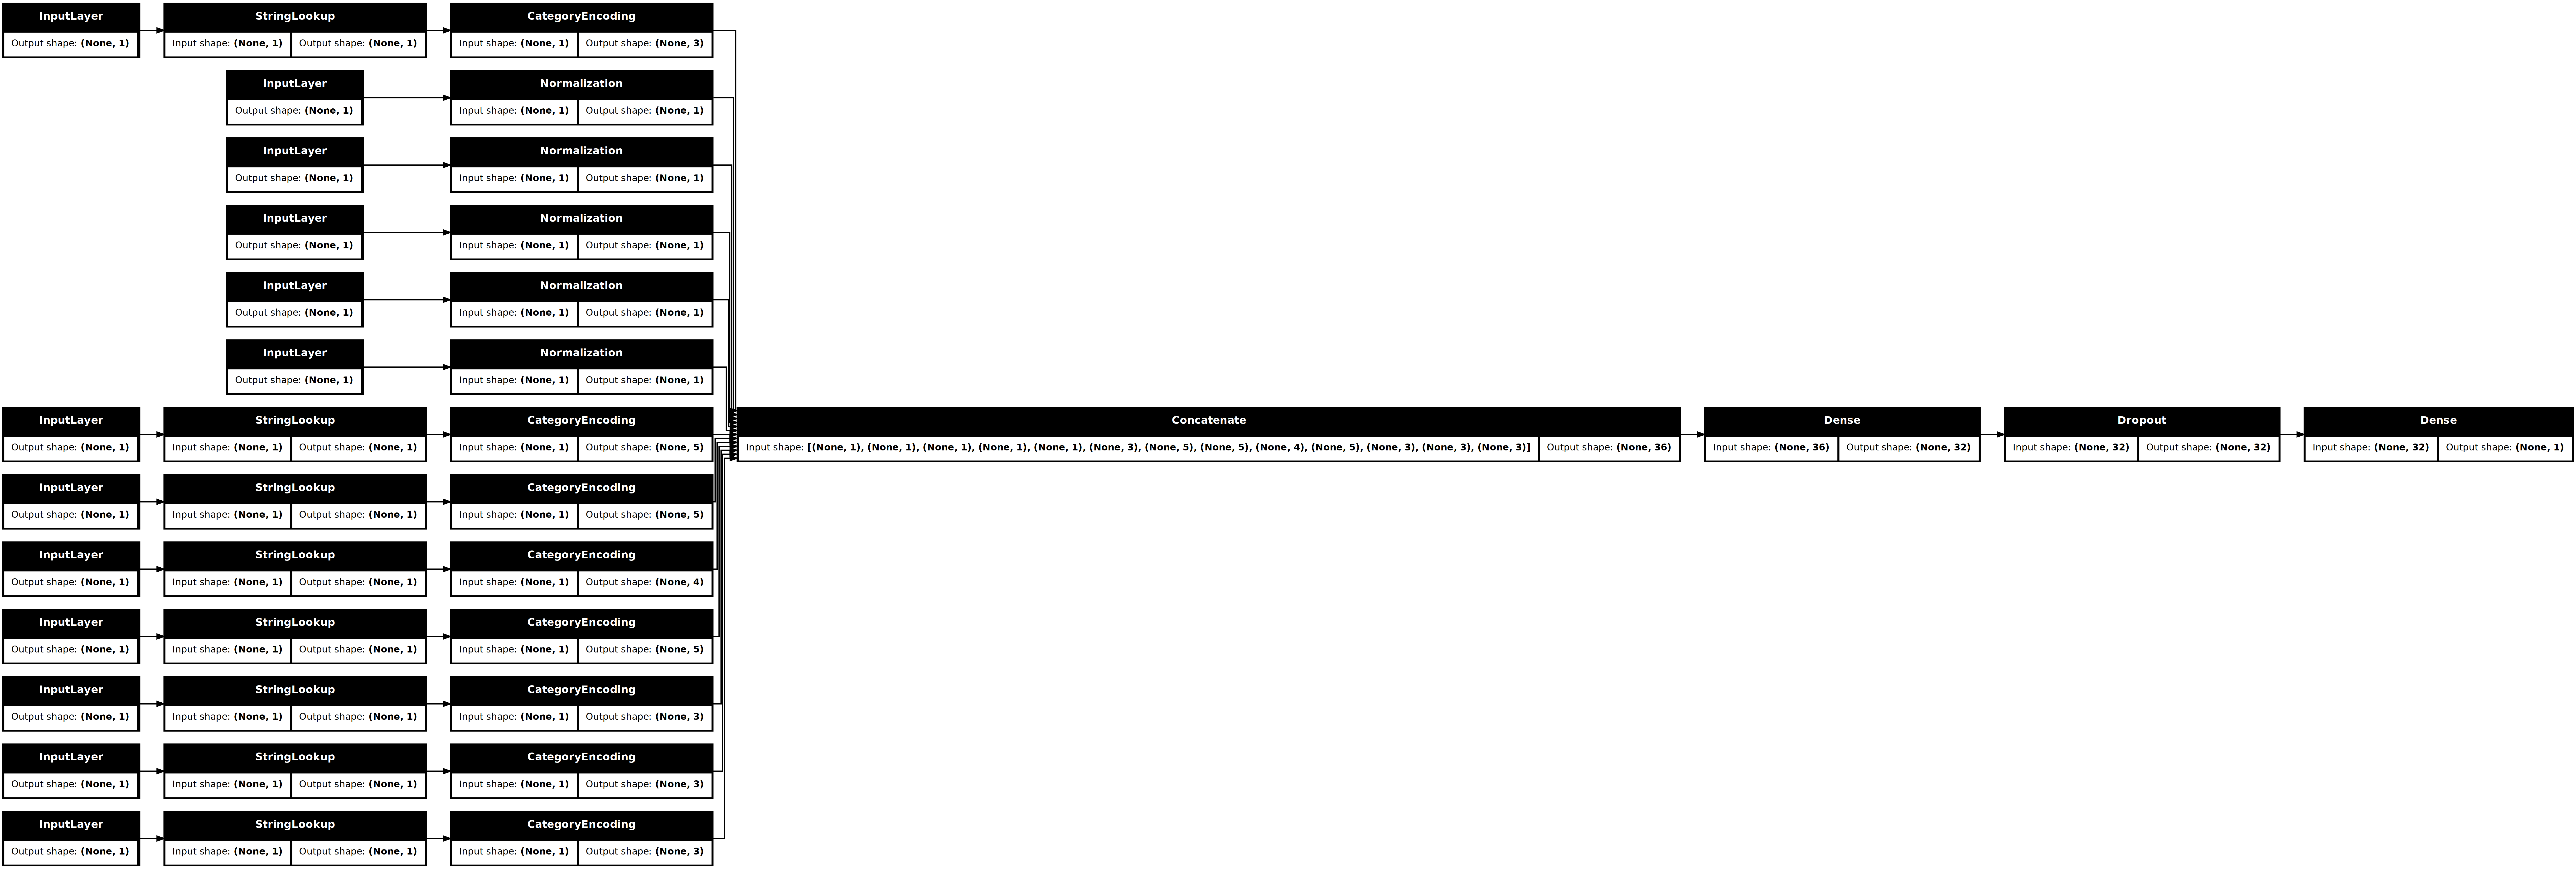

In [25]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [26]:
model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4939 - loss: 0.7326 - val_accuracy: 0.4914 - val_loss: 0.6961
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5000 - loss: 0.7048 - val_accuracy: 0.4907 - val_loss: 0.6947
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5012 - loss: 0.6977 - val_accuracy: 0.4907 - val_loss: 0.6942
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5043 - loss: 0.6944 - val_accuracy: 0.4907 - val_loss: 0.6941
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4985 - loss: 0.6937 - val_accuracy: 0.4907 - val_loss: 0.6939
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5018 - loss: 0.6931 - val_accuracy: 0.4907 - val_loss: 0.6938
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5032 - loss: 0.6932 - val_accuracy: 0.4907 - val_loss: 0.6938
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4967 - loss: 0.6934 - val_accuracy: 0.4907 - val_loss:

In [27]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4973 - loss: 0.6944 
Accuracy 0.5052557587623596


In [28]:
model.save('NFier.keras')
loaded_model = tf.keras.models.load_model('NFier.keras')

In [29]:
loaded_model.predict(test_ds)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


array([[ 0.16552234],
       [ 0.00848027],
       [-0.04266999],
       ...,
       [ 0.04949995],
       [ 0.01058294],
       [ 0.14566082]], dtype=float32)

In [30]:
tf.nn.sigmoid(loaded_model.predict(test_ds))

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


<tf.Tensor: shape=(2854, 1), dtype=float32, numpy=
array([[0.54128635],
       [0.5021201 ],
       [0.4893341 ],
       ...,
       [0.51237243],
       [0.50264573],
       [0.53635097]], dtype=float32)>